In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device : {device}")

using device : cpu


In [6]:
data = pd.read_csv("fmnist_small.csv")
data.shape

(6000, 785)

In [7]:
data.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0


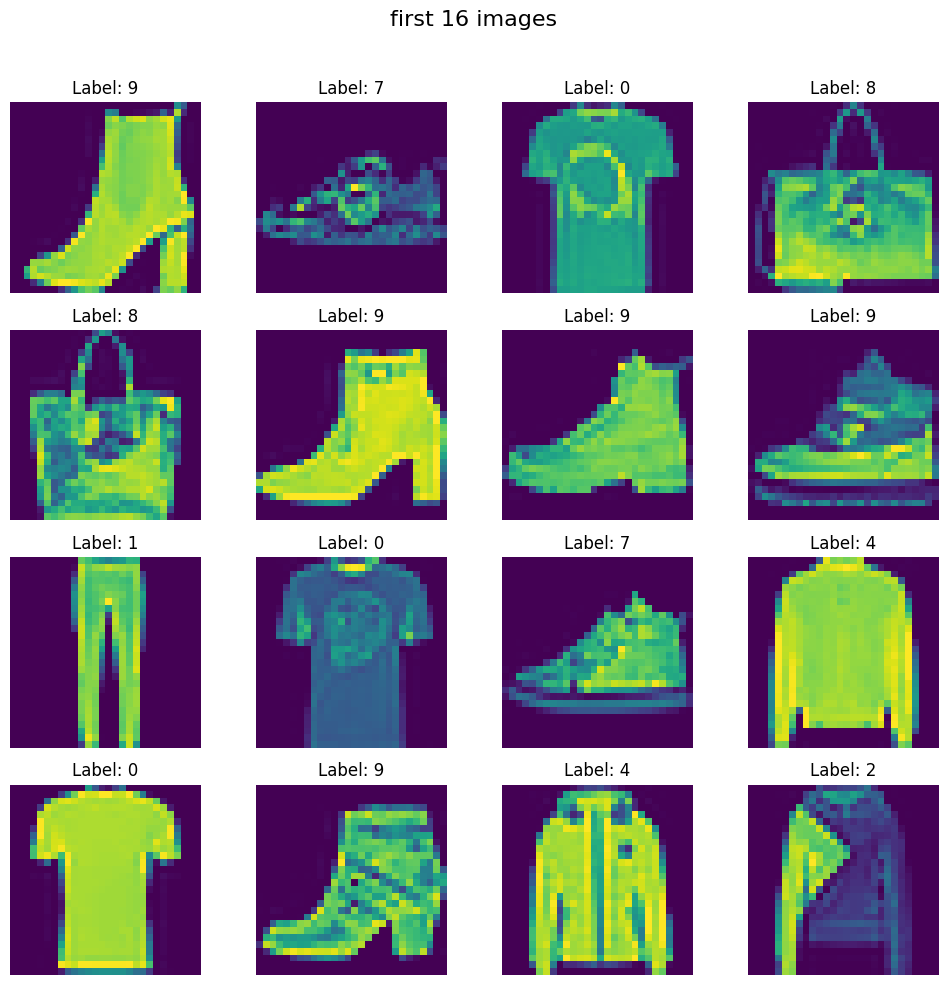

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = data.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Label: {data.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [10]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4800, 784), (1200, 784), (4800,), (1200,))

In [11]:
X_train = X_train/255.0
X_test = X_test/255.0

In [17]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype= torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [45]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
train_loader

In [46]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader

In [21]:
### lets start

In [35]:
class my_nn(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(64,10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [36]:
learning_rate = 0.01
epochs = 10

In [37]:
model = my_nn(1)
model

my_nn(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= learning_rate, weight_decay=1e-4)

criterion, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0.0001
 ))

In [39]:
## training Loop

for epoch in range(epochs):
    total_epoch_loss = 0

    for batch_features, batch_label in train_loader:

        ## forward pass
        output = model(batch_features)

        ## calculate loss 
        loss = criterion(output, batch_label)
        
        ## backward pass
        optimizer.zero_grad()

        ## 
        loss.backward()

        ## update grads
        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f"Epoch : {epoch+1}, loss : {avg_loss}")

Epoch : 1, loss : 1.4742388474941253
Epoch : 2, loss : 0.840606219569842
Epoch : 3, loss : 0.6765696829557419
Epoch : 4, loss : 0.6054467648267746
Epoch : 5, loss : 0.530500219464302
Epoch : 6, loss : 0.4751127564907074
Epoch : 7, loss : 0.4277874015768369
Epoch : 8, loss : 0.39240542834003767
Epoch : 9, loss : 0.3711510616540909
Epoch : 10, loss : 0.33640153527259825


In [40]:
model.eval()

my_nn(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [44]:
test_loader.features.shape

torch.Size([1200, 1, 28, 28])

In [47]:
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        out = model(batch_features)

        _ , predicted = torch.max(out,1)

        total = total + batch_labels.shape[0]

        correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8433333333333334
